In [ ]:
!pip install transformers peft accelerate datasets sentencepiece --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TextDataset, DataCollatorForLanguageModeling,
    Trainer, TrainingArguments
)
from peft import get_peft_model, LoraConfig, TaskType

print("Using:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using: NVIDIA A100-SXM4-40GB


In [ ]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [ ]:
import json
# Load train, dev, and test data
train_data = load_data('/content/drive/MyDrive/Colab Notebooks/datasets/train.json')
dev_data = load_data('/content/drive/MyDrive/Colab Notebooks/datasets/dev.json')
test_data = load_data('/content/drive/MyDrive/Colab Notebooks/datasets/test.json')

In [ ]:
# Check the keys of the train_data dictionary
print(train_data.keys())  # Check the keys in the dictionary
print(dev_data.keys())    # Check the keys in the dev_data dictionary
print(test_data.keys())   # Check the keys in the test_data dictionary

dict_keys(['documents', 'labels'])
dict_keys(['documents', 'labels'])
dict_keys(['documents', 'labels'])


In [ ]:
def extract_text(data, key='documents'):
    # Extract the 'text' field from each dictionary in the list under the 'documents' key
    return [entry['text'] for entry in data[key]]  # Ensure 'text' is the correct field name

In [ ]:
train_texts = extract_text(train_data, key='documents')
dev_texts = extract_text(dev_data, key='documents')
test_texts = extract_text(test_data, key='documents')

# Print the first 5 texts to verify
print(train_texts[:1])

["NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\nThis NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT (“Agreement”) is made by and between:\n(i) the Office of the United Nations High Commissioner for Refugees, having its headquarters located at 94 rue de Montbrillant, 1202 Geneva, Switzerland (hereinafter “UNHCR” or the “Discloser”); and\n(ii) ________________________ , a company established in accordance with the laws of ________________________ and having its principal offices located at ________________________________________________ (hereinafter the “Bidder” or the “Recipient”).\nThe Discloser and Recipient are also referred to collectively as the “Parties” and individually as a “Party”.\nRECITALS\nWHEREAS in connection with RFP/2014/620, Request for Proposal for the provision Off-the-shelf Soft-skill, IT Online and HR specific E-learning Courses (the “RFP”), it is advantageous to share certain data and information with the Bidder participating in the RFP;\nWHEREAS UNHCR agrees to pro

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/datasets/legal_docs.txt", "w", encoding="utf-8") as f:
    for doc in train_texts:
        doc = doc.replace("\n", " ").strip()  # Optional: flatten formatting
        f.write(doc + "\n\n")  # Separate docs with double line breaks

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/datasets/legal_eval.txt", "w", encoding="utf-8") as f:
    for doc in dev_texts:
        doc = doc.replace("\n", " ").strip()
        f.write(doc + "\n\n")

In [ ]:
output_path = "/content/drive/MyDrive/Colab Notebooks/datasets/legal_docs.txt"

with open(output_path, "r", encoding="utf-8") as f:
    preview = f.read().split("\n\n")[:4]
    for i, doc in enumerate(preview, 1):
        print(f"\n--- Document {i} ---\n{doc[:500]}...\n")


--- Document 1 ---
NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT This NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT (“Agreement”) is made by and between: (i) the Office of the United Nations High Commissioner for Refugees, having its headquarters located at 94 rue de Montbrillant, 1202 Geneva, Switzerland (hereinafter “UNHCR” or the “Discloser”); and (ii) ________________________ , a company established in accordance with the laws of ________________________ and having its principal offices located at ______________...


--- Document 2 ---
NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIPATION Table of Content 1 Eligibility ..........................................................................................................................................2 2 Procedure and terms of participation ...............................................................................................3 3 Payment ......................................................................................

In [ ]:
# model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
# tokenizer = GPT2Tokenizer.from_pretrained(model_name)
# tokenizer.pad_token = tokenizer.eos_token

# model = GPT2LMHeadModel.from_pretrained(model_name)
# model.resize_token_embeddings(len(tokenizer))

In [ ]:
# Step 3: Load Pretrained LLaMA-3 Instruct Model
model_name = "Qwen/Qwen2.5-7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", trust_remote_code=True, torch_dtype=torch.float16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
def load_dataset(file_path, tokenizer, block_size=512):
    return TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size
    )

train_dataset = load_dataset("/content/drive/MyDrive/Colab Notebooks/datasets/legal_docs.txt", tokenizer)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

/usr/local/lib/python3.11/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=32,
    lora_dropout=0.05
)
model = get_peft_model(model, peft_config)

In [ ]:
os.environ["WANDB_DISABLED"] = "true"
training_args = TrainingArguments(
    output_dir="./qwen_legal_model",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=1,  # Reduce batch size to avoid CUDA OOM
    gradient_accumulation_steps=4,  # Compensate for small batch size
    save_steps=500,
    save_total_limit=2,
    logging_steps=100,
    prediction_loss_only=True,
    fp16=True
)

# Step 8: Train the Model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    tokenizer=tokenizer
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-15-6fa1b15849d1>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
100,1.584900
200,1.541300
300,1.524500
400,1.513100
500,1.500800
600,1.524700
700,1.495600
800,1.493700
900,1.479500
1000,1.489700


TrainOutput(global_step=1326, training_loss=1.5049769083658855, metrics={'train_runtime': 801.9582, 'train_samples_per_second': 6.614, 'train_steps_per_second': 1.653, 'total_flos': 1.1524898798803354e+17, 'train_loss': 1.5049769083658855, 'epoch': 3.0})

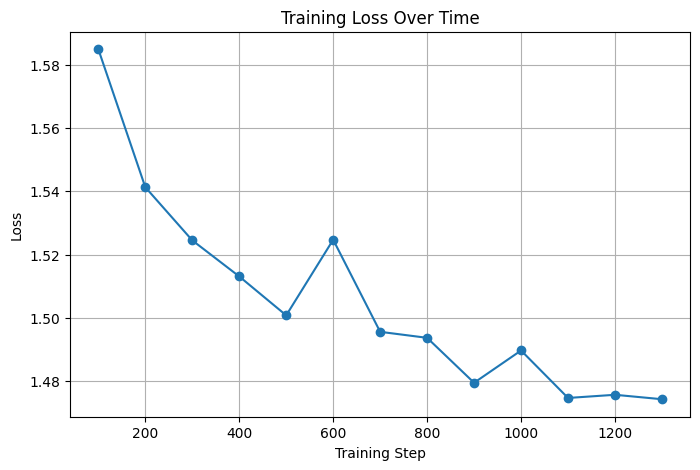

In [ ]:
import matplotlib.pyplot as plt

# Extract loss from trainer logs
log_history = trainer.state.log_history
loss_values = [entry["loss"] for entry in log_history if "loss" in entry]
steps = [entry["step"] for entry in log_history if "loss" in entry]

# Plot the loss
plt.figure(figsize=(8, 5))
plt.plot(steps, loss_values, marker='o')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.show()


In [ ]:
from transformers import TextDataset

eval_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="/content/drive/MyDrive/Colab Notebooks/datasets/legal_eval.txt",
    block_size=512
)

/usr/local/lib/python3.11/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (141947 > 131072). Running this sequence through the model will result in indexing errors


In [ ]:
eval_results = trainer.evaluate(eval_dataset=eval_dataset)
print(eval_results)

{'eval_loss': 1.507294774055481, 'eval_runtime': 11.961, 'eval_samples_per_second': 23.159, 'eval_steps_per_second': 2.926, 'epoch': 3.0}


In [ ]:
import math
perplexity = math.exp(eval_results["eval_loss"])
print(f"Perplexity: {perplexity:.2f}")

Perplexity: 4.51


In [ ]:
# Step 8: Save Model & Tokenizer
trainer.save_model("/content/drive/MyDrive/Colab Notebooks/model_nlp")
tokenizer.save_pretrained("/content/drive/MyDrive/Colab Notebooks/model_nlp")

('/content/drive/MyDrive/Colab Notebooks/model_nlp/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/model_nlp/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/model_nlp/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/model_nlp/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/model_nlp/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/model_nlp/tokenizer.json')

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/model_nlp"

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True).to("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
model.eval()
prompt = "THIS AGREEMENT is "
inputs = tokenizer(prompt, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_length=300,
        temperature=0.7,
        top_p=0.95,
        do_sample=True
    )

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("\nGenerated Clause:\n")
print(generated_text)


Generated Clause:

THIS AGREEMENT is  entered into as of the date indicated below by and between:  [Name of Buyer], whose principal place of business is at [Address], whose attention is directed to the following information and representations, and [Name of Seller], whose principal place of business is at [Address].  WHEREAS, the parties hereto have agreed that the buyer will purchase from the seller, and the seller agrees to sell to the buyer, certain equipment;  NOW, THEREFORE, for and in consideration of the mutual covenants contained herein and other good and valuable consideration, the receipt and sufficiency of which are hereby acknowledged, the parties agree as follows:  1. Definitions. For purposes of this Agreement:  (a) “Affiliate” means any person directly or indirectly controlling, controlled by or under common control with another person, where the term “control” (including the terms “controlling,” “controlled by” and “under common control with”) means the power, whether 

In [ ]:
!pip install bert-score

In [ ]:
import json
from bert_score import score
reference_path = "/content/drive/MyDrive/Colab Notebooks/datasets/dev.json"
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def extract_text(data, key='documents'):
    return [entry.get('text', '') for entry in data.get(key, [])]

reference_data = load_data(reference_path)
reference_texts = extract_text(reference_data)

candidates = [generated_text]
references = [reference_texts[0]]  # you can select based on length or index

P, R, F1 = score(candidates, references, lang="en", verbose=True)

print("\n🔍 BERTScore:")
print(f"Precision: {P.mean().item():.4f}")
print(f"Recall: {R.mean().item():.4f}")
print(f"F1 Score: {F1.mean().item():.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.21 seconds, 4.73 sentences/sec

🔍 BERTScore:
Precision: 0.8175
Recall: 0.7948
F1 Score: 0.8060
